## Lollipop Experiments

**NOTE:** Please confirm the results in this notebook after making any changes to the repository.

This notebook is written to demoinstrate LID estimation on the lollipop dataset. The lollipop dataset is a synthetic dataset that is good for testing out whether our estimator is truly estimating LID or not. The dataset contains three regions: (1) the candy has LID of 2, (2) the stick has LID of 1, and (3) the dot that has LID of 0. Run the following piece of code to visualize:

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


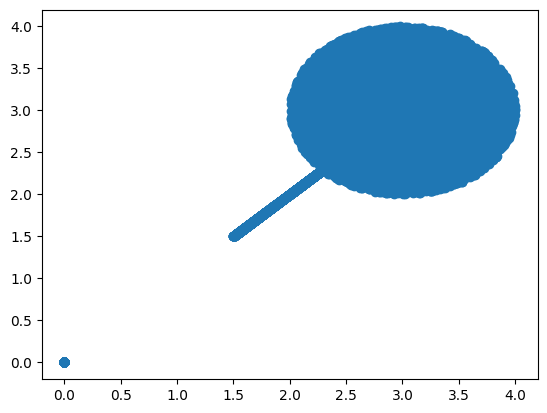

In [6]:

import sys
sys.path.append('..')
import torch
import matplotlib.pyplot as plt
from model_zoo.datasets.generated import Lollipop
%load_ext autoreload
%autoreload 2

# set to change device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)
lollipop = Lollipop(
    name='lollipop',
    role='train',
    d=2,
    size=15000,
    seed=0)
plt.scatter(*lollipop.data_projected.T)
plt.show()


## Diffusion experiments (VP-SDE)

In this section, we will train the variance preserving variant of diffusion model on the lollipop dataset and then use different LID estimation techniques on it.

In [17]:
%autoreload 2
from torch import optim
from model_zoo.networks.toy import SimpleDiffusionMLP
from model_zoo.density_estimator.diffusions import VPSDE_Diffusion

# (1) Setup the model and optimizer
network = SimpleDiffusionMLP(2, hidden_sizes=(512, 512)).to(device)
model = VPSDE_Diffusion(score_network=network, data_shape=(2,)) # This class contains the actual diffusion logic
optimizer = optim.Adam(network.parameters(), lr=1e-3)

# (2) Start training the model itself:
import torch
import torch.nn.functional as F
from tqdm import tqdm

epochs = 1000
batch_size = 100 # Here equal to the dataset size of 100
loss_history = []

rng = tqdm(range(epochs), desc = f"Initialize training for {epochs} epochs")
for epoch in rng:
    for x in lollipop.data_projected.split(batch_size):
        x = x.to(device)
        batch_size = x.shape[0]
        
        loss = model.loss(x)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
    loss_history.append(loss.item())
    if len(loss_history) >= 100:
        rng.set_description(f"Training with average loss {sum(loss_history) / len(loss_history):.4f}")
        loss_history.clear()

Initialize training for 1000 epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Training with average loss 0.3782: 100%|██████████| 1000/1000 [03:20<00:00,  5.00it/s]


Now run the following piece of code to visualize the samples from the diffusion to make sure it has been trained properly.

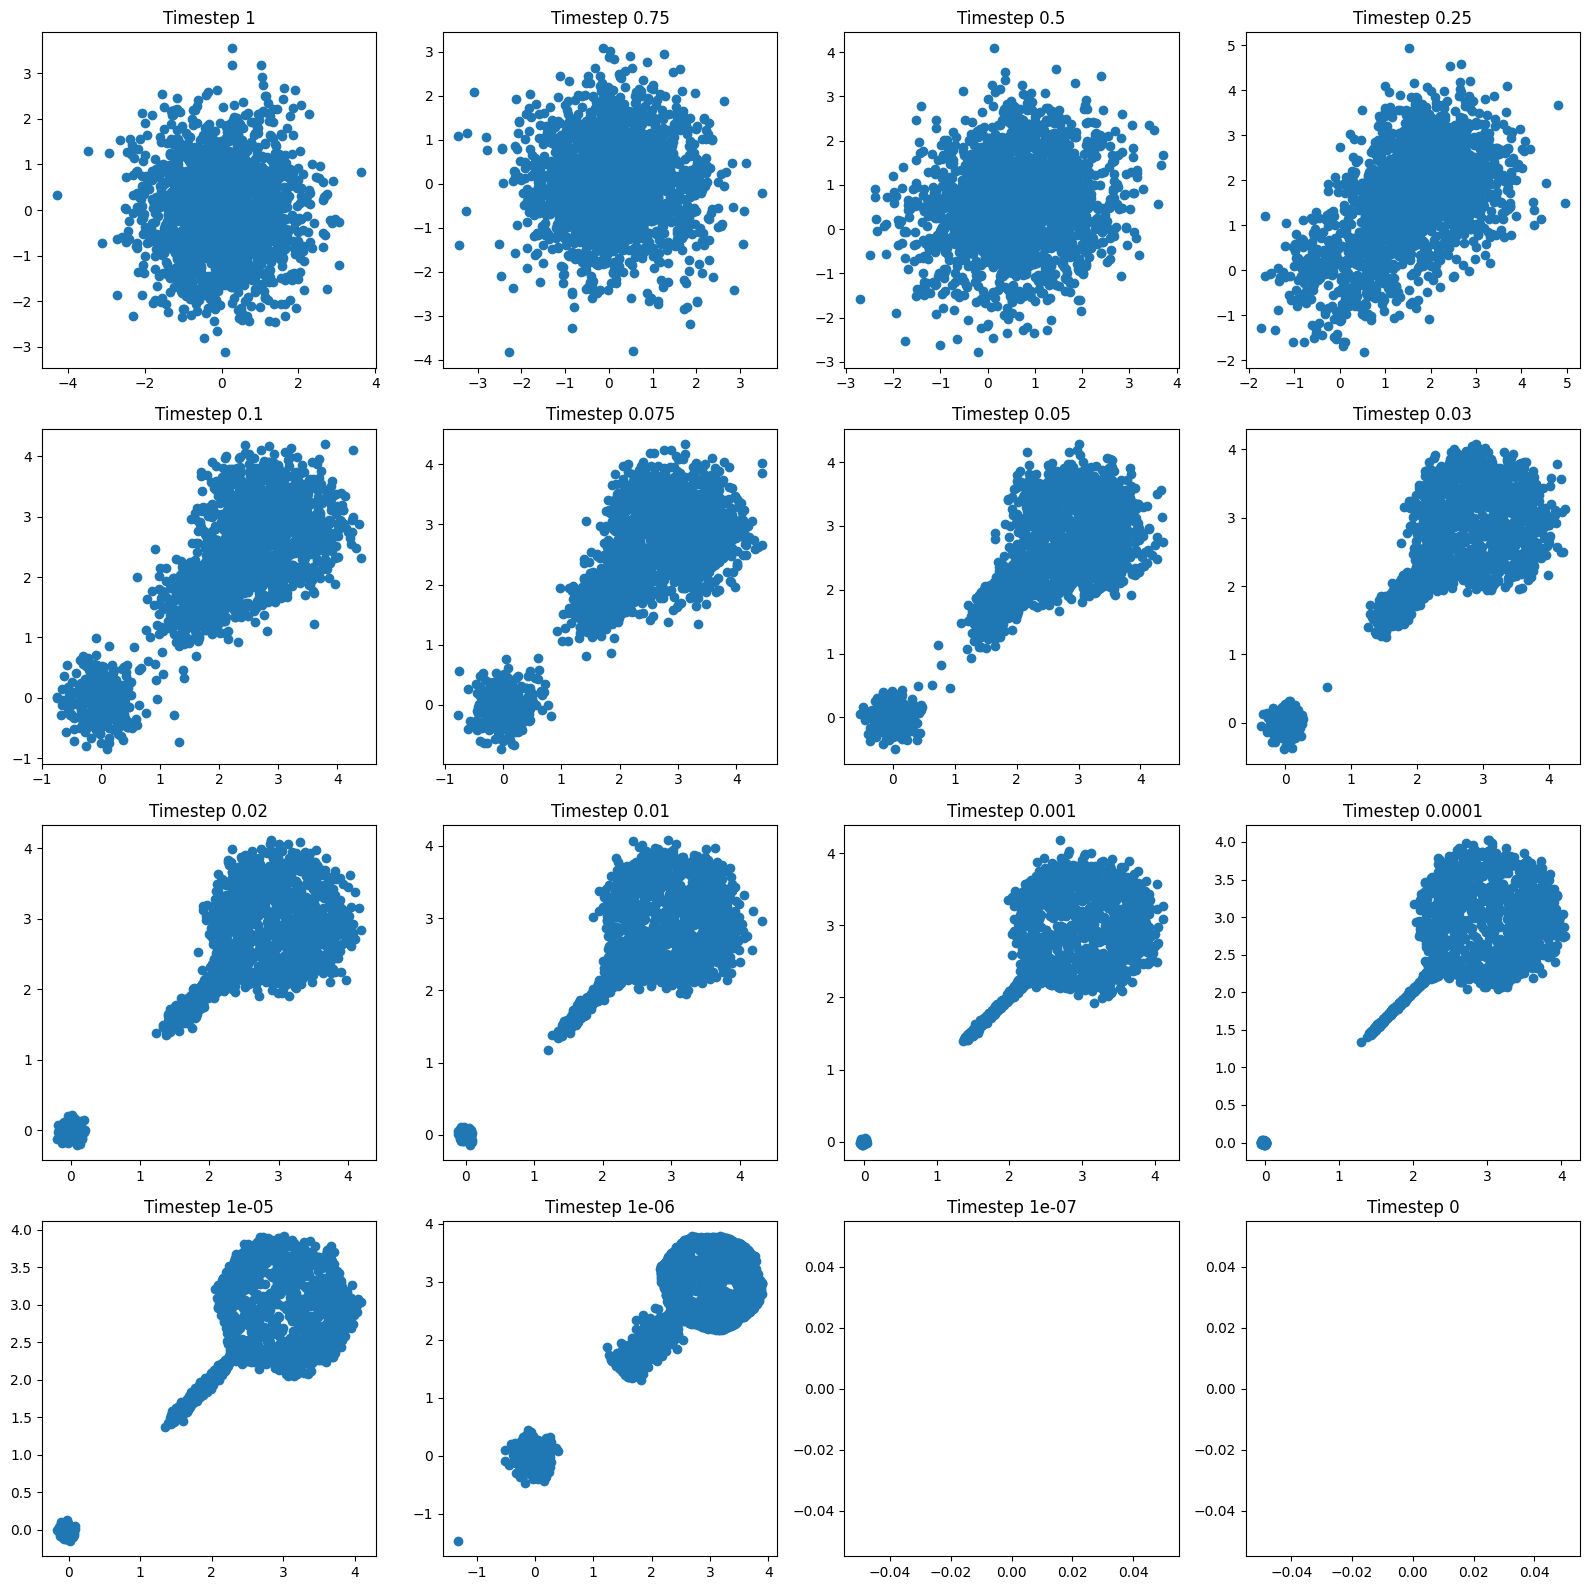

In [18]:
timesteps = (1, 0.75, 0.5, 0.25, 1e-1, 7.5e-2, 5e-2, 3e-2, 2e-2, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 0)
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
assert len(timesteps) == len(axes.flatten())

for ax, eps in zip(axes.flatten(), timesteps): # Generate 1k points and plot them
    gen_sample = model.sample(2000, device=device, eps=eps) 
    ax.scatter(*gen_sample.cpu().T)
    ax.set_title(f'Timestep {eps}')
    
fig.tight_layout()

### Likelihood values

One facet of the score-based diffusions that we incorporate in our study is that it is possible to estimate the likelihood of a sample under the model. Moreover, the loss is also set in a way that promotes increasing the likelihood for training data. In the following, we provide a heatmap of the likelihood values for the samples in the lollipop dataset. Note that the likelihood estimator has a hyperparameter called `eps` which greatly impacts the likelihood values. The following heatmap is generated using different values of that hyperparameter.

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [02:13<00:00,  8.32s/it]


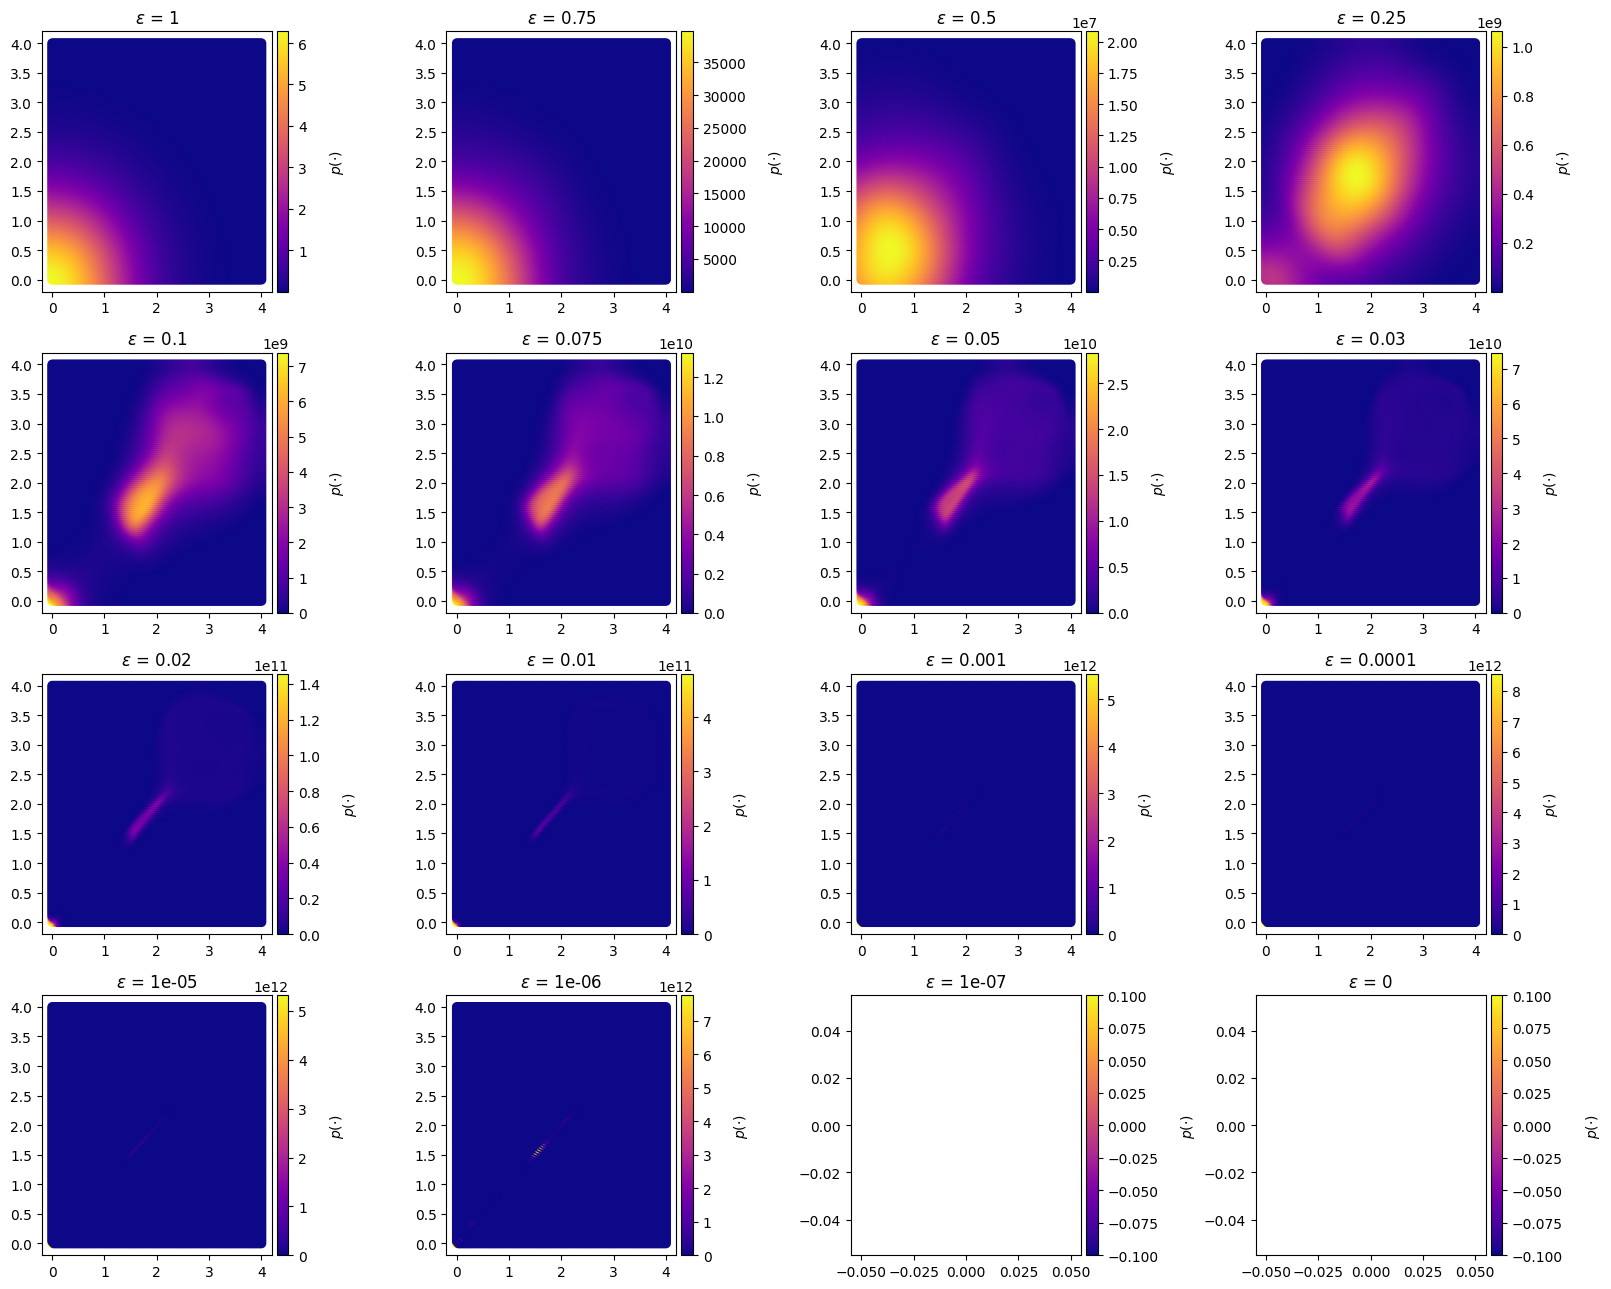

In [19]:
# Create a 2D heatmap of the dataset with the model's density on the dataset

from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np 
import math

# Create an N by 2 dataset of points on a grid between 0 and 4
N = 123
x = np.linspace(0, 4, N)
y = np.linspace(0, 4, N)
X, Y = np.meshgrid(x, y)
data = np.vstack([X.ravel(), Y.ravel()]).T
data = torch.tensor(data, dtype=torch.float32).to(device)

epsilons = (1, 0.75, 0.5, 0.25, 1e-1, 7.5e-2, 5e-2, 3e-2, 2e-2, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 0)

fig, axes = plt.subplots(4, 4, figsize=(16, 13))
assert len(epsilons) == len(axes.flatten())

for ax, t in tqdm(zip(axes.flatten(), epsilons), total=len(epsilons)): # Generate 1k points and plot them
    all_log_probs = model.log_prob(data, eps=t, device=device, verbose=0)
    # turn all_log_probs into their ranks
    
    heatmap = torch.exp(all_log_probs.cpu())
    # Graph the norms
    s = ax.scatter(*data.T.cpu().numpy(), c=heatmap, cmap='plasma')
    
    ax.set_title(f'$\\epsilon$ = {t}')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(s, cax=cax, orientation='vertical')

    # Add a label to the colorbar
    cbar.set_label('$p(\\cdot)$', rotation=90, labelpad=15)
fig.tight_layout()


### Stanczuk's LID

Here, we will focus on the Stanczuk's LID estimation technique. We will use the `stanczuk_lid` method from the diffusion model. All of the LID estimators we consider has a scale hyperparameter written as `r`. When `r` is set to a very small negative value, the LID estimator will be very sensitive to the local density of the samples and will thus predict the ambient dimension. By contrast, when `r` is set too large, the LID estimator will be insensitive to the local density of the samples and will thus predict the intrinsic dimension as 0. The following code shows the LID estimates for different values of `r` for the Lollipop dataset.

computing LID:   0%|          | 0/16 [00:00<?, ?it/s]

computing LID: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


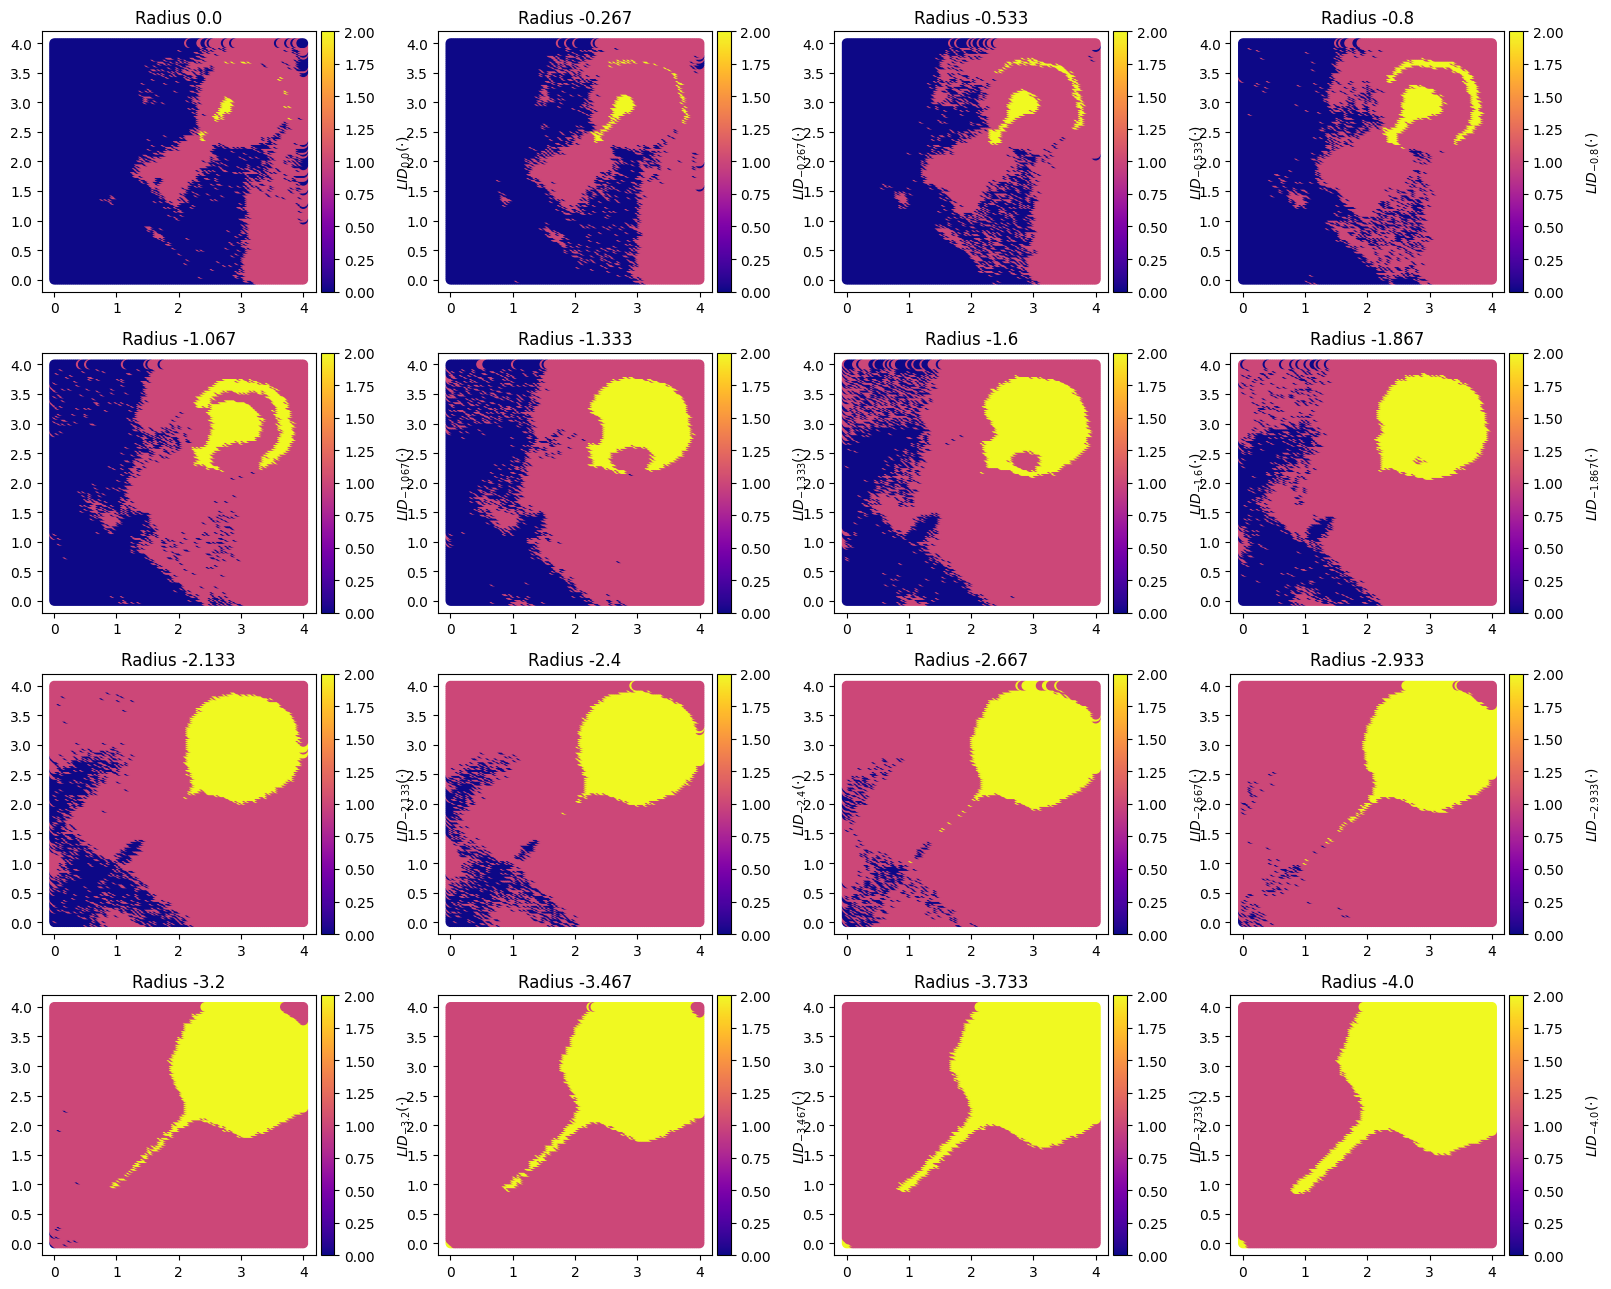

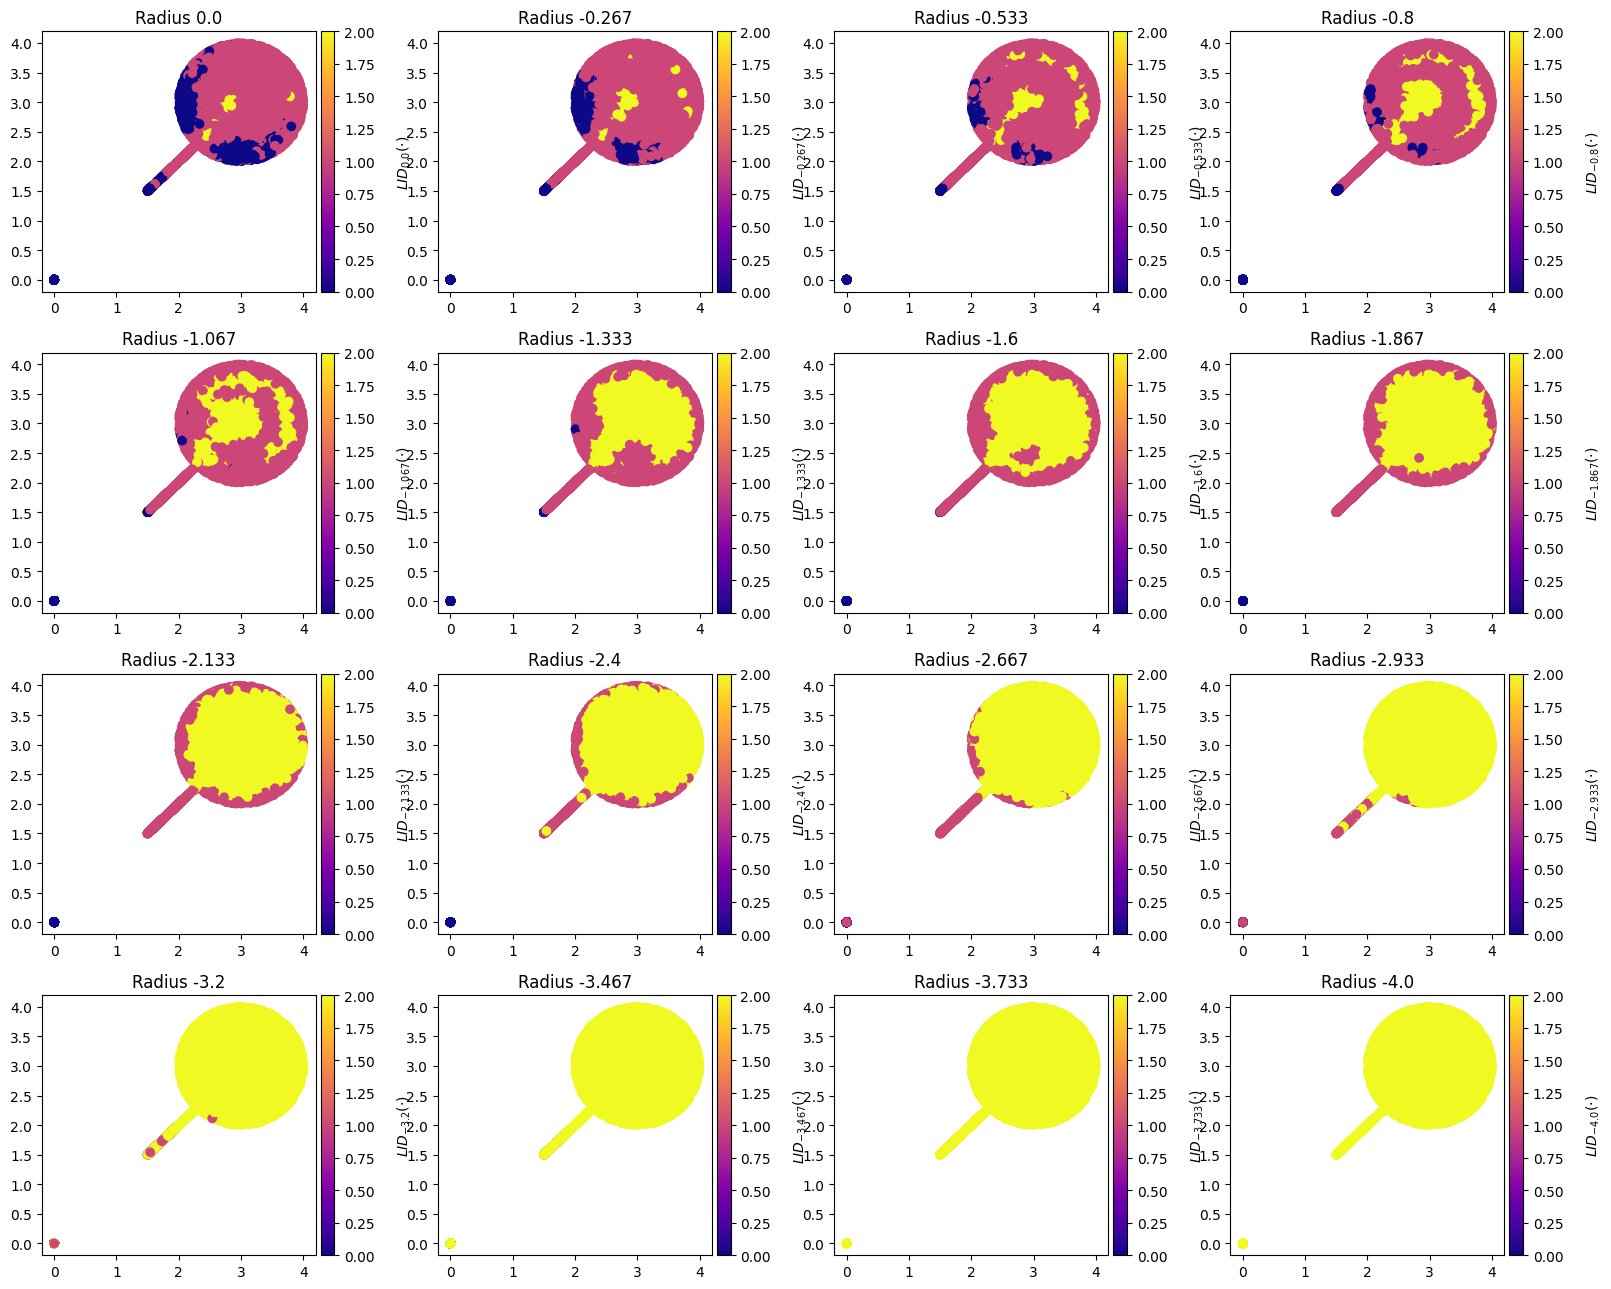

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np 

# Create an N by 2 dataset of points on a grid between 0 and 4
N = 123
x = np.linspace(0, 4, N)
y = np.linspace(0, 4, N)
X, Y = np.meshgrid(x, y)
data = np.vstack([X.ravel(), Y.ravel()]).T
data = torch.tensor(data, dtype=torch.float32).to(device)

def show_everything(data):
    radii = np.linspace(0, -4, 16)

    fig, axes = plt.subplots(4, 4, figsize=(16, 13))
    assert len(radii) == len(axes.flatten())

    for ax, r in tqdm(zip(axes.flatten(), radii), total=len(radii), desc="computing LID"): # Generate 1k points and plot them
        
        all_lid = model.lid(data, r=r, device=device).cpu()
        
        # Graph the norms
        s = ax.scatter(*data.cpu().T, c=all_lid, cmap='plasma', vmin=0, vmax=2)
        
        ax.set_title(f'Radius {round(r, 3)}')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(s, cax=cax, orientation='vertical')
        
        cbar.set_label(f'$LID_{{{round(r, 3)}}}(\\cdot)$', rotation=90, labelpad=15)


        
    fig.tight_layout()

show_everything(data)
show_everything(lollipop.data_projected)

## Diffusion experiments (VE-SDE)

In this section, we will train a diffusion model on the lollipop dataset and then use different LID estimation techniques on it.

In [19]:
%autoreload 2
from torch import optim
from model_zoo.networks.toy import SimpleDiffusionMLP
from model_zoo.density_estimator.diffusions import VESDE_Diffusion

# (1) Setup the model and optimizer
network = SimpleDiffusionMLP(2, hidden_sizes=(512, 512)).to(device)
model = VESDE_Diffusion(score_network=network, data_shape=(2,)) # This class contains the actual diffusion logic
optimizer = optim.Adam(network.parameters(), lr=1e-3)

# (2) Start training the model itself:
import torch
import torch.nn.functional as F
from tqdm import tqdm

epochs = 1000
batch_size = 100 # Here equal to the dataset size of 100
loss_history = []

rng = tqdm(range(epochs), desc = f"Initialize training for {epochs} epochs")
for epoch in rng:
    for x in lollipop.data_projected.split(batch_size):
        x = x.to(device)
        batch_size = x.shape[0]
        
        loss = model.loss(x)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
    loss_history.append(loss.item())
    if len(loss_history) >= 100:
        rng.set_description(f"Training with average loss {sum(loss_history) / len(loss_history):.4f}")
        loss_history.clear()

Initialize training for 1000 epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Training with average loss 0.6716: 100%|██████████| 1000/1000 [02:13<00:00,  7.52it/s]


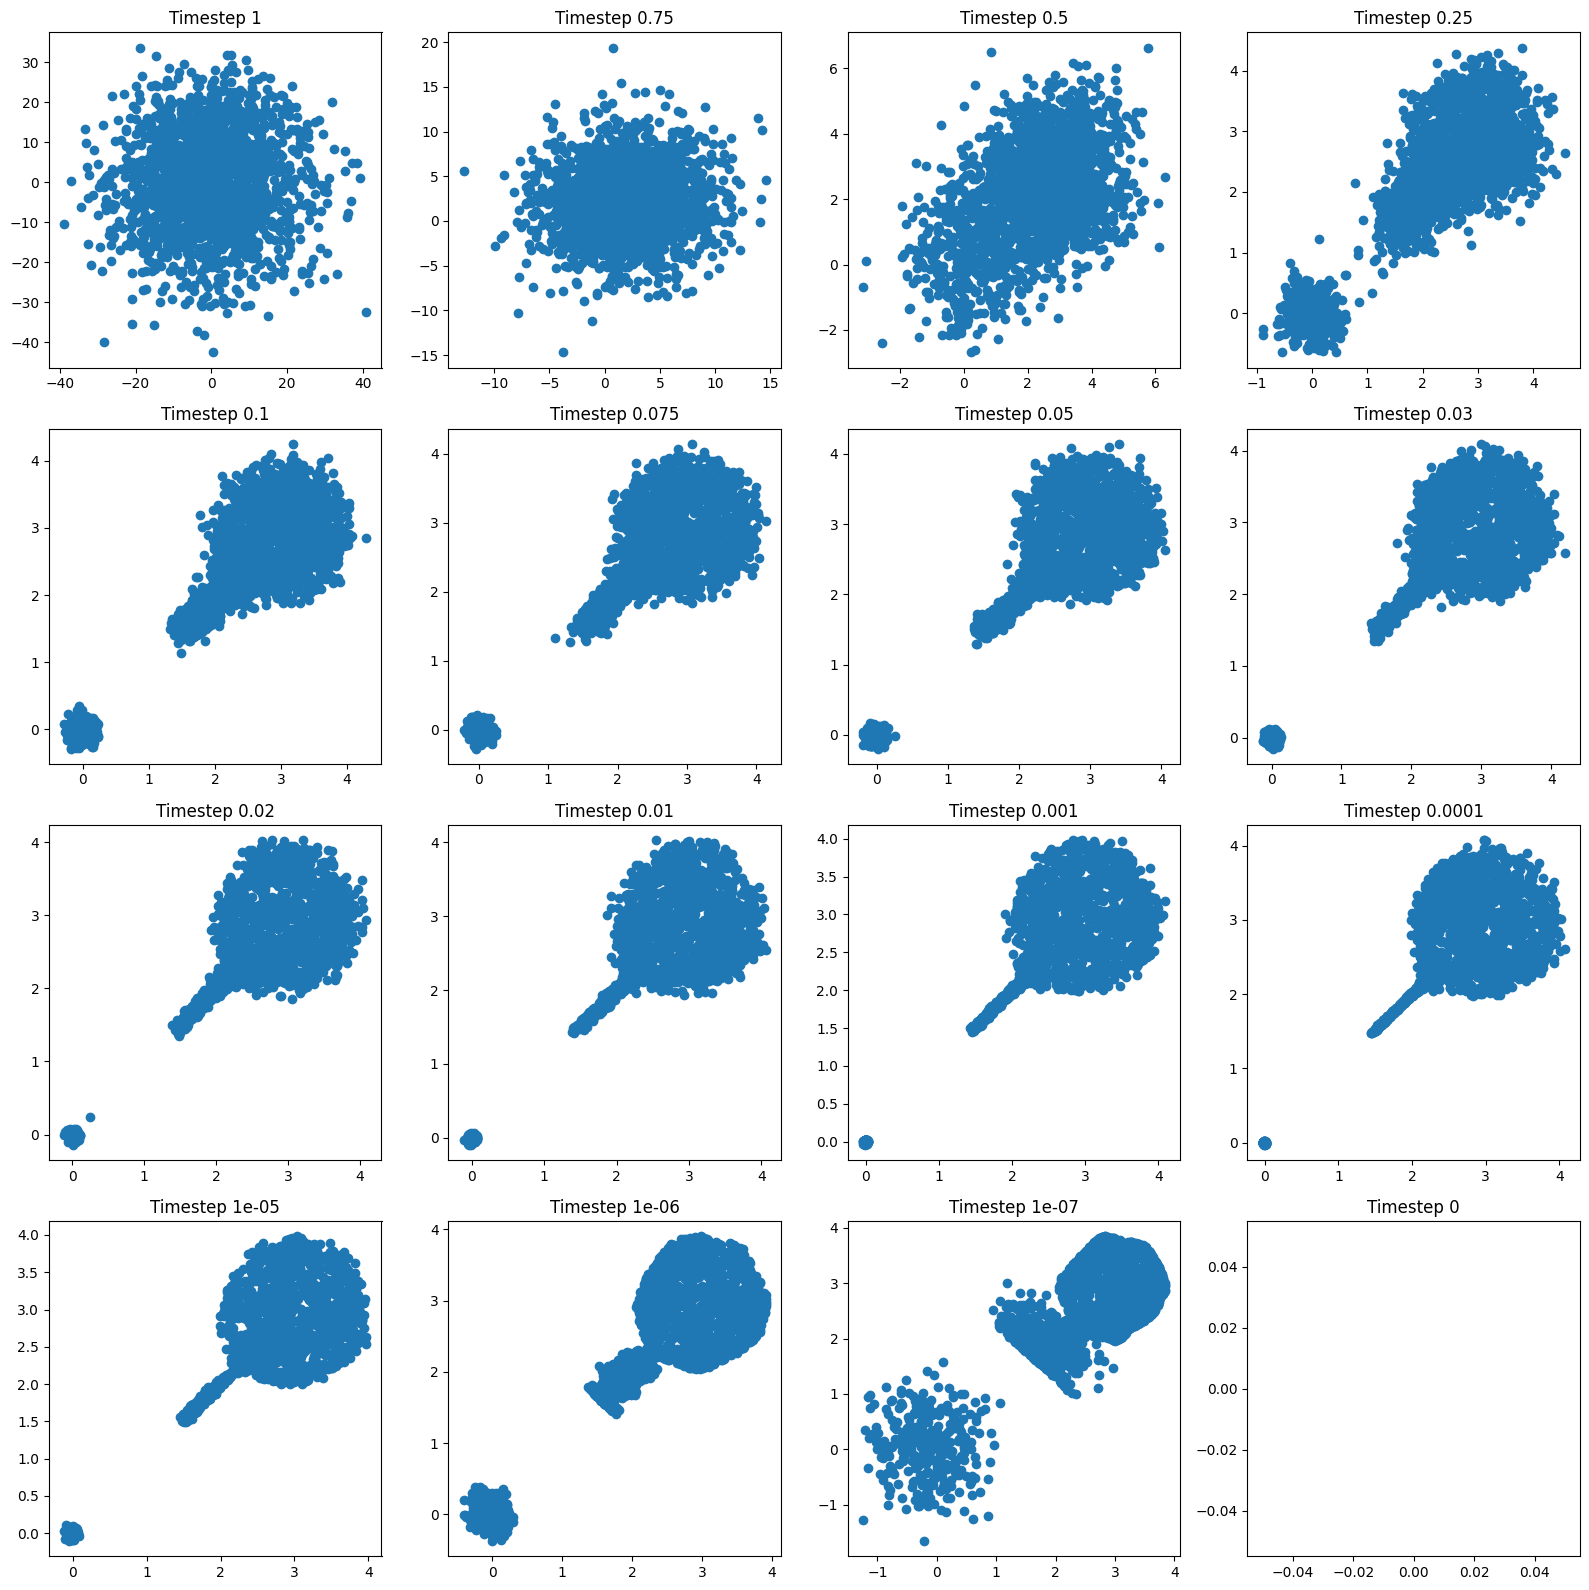

: 

In [25]:
timesteps = (1, 0.75, 0.5, 0.25, 1e-1, 7.5e-2, 5e-2, 3e-2, 2e-2, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 0)
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
assert len(timesteps) == len(axes.flatten())

for ax, eps in zip(axes.flatten(), timesteps): # Generate 1k points and plot them
    gen_sample = model.sample(2000, device=device, eps=eps) 
    ax.scatter(*gen_sample.cpu().T)
    ax.set_title(f'Timestep {eps}')
    
fig.tight_layout()

# Log probs

Here we test out the log probability function for the VE-SDE models.

100%|██████████| 16/16 [01:06<00:00,  4.18s/it]


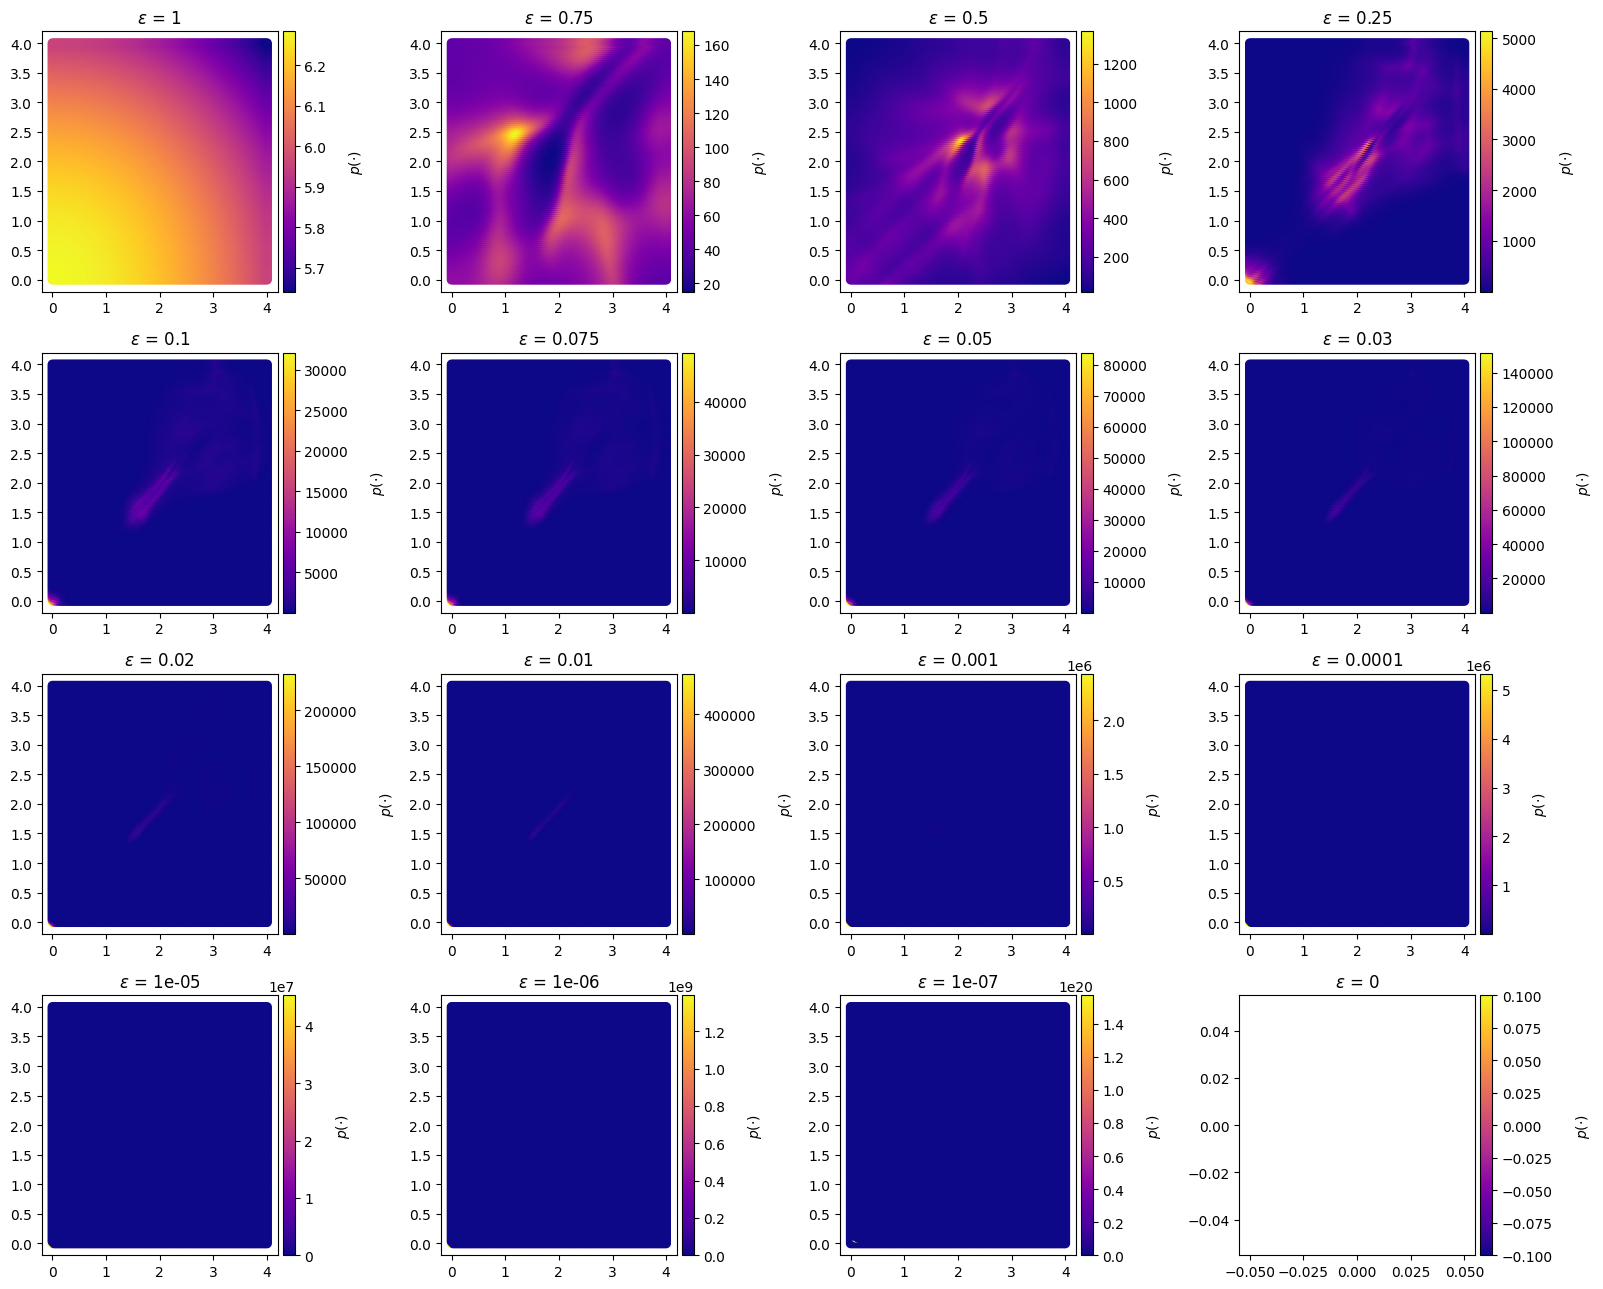

In [23]:
# Create a 2D heatmap of the dataset with the model's density on the dataset

from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np 
import math

# Create an N by 2 dataset of points on a grid between 0 and 4
N = 123
x = np.linspace(0, 4, N)
y = np.linspace(0, 4, N)
X, Y = np.meshgrid(x, y)
data = np.vstack([X.ravel(), Y.ravel()]).T
data = torch.tensor(data, dtype=torch.float32).to(device)

epsilons = (1, 0.75, 0.5, 0.25, 1e-1, 7.5e-2, 5e-2, 3e-2, 2e-2, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 0)

fig, axes = plt.subplots(4, 4, figsize=(16, 13))
assert len(epsilons) == len(axes.flatten())

for ax, t in tqdm(zip(axes.flatten(), epsilons), total=len(epsilons)): # Generate 1k points and plot them
    all_log_probs = model.log_prob(data, eps=t, device=device, verbose=0)
    # turn all_log_probs into their ranks
    
    heatmap = torch.exp(all_log_probs.cpu())
    # Graph the norms
    s = ax.scatter(*data.T.cpu().numpy(), c=heatmap, cmap='plasma')
    
    ax.set_title(f'$\\epsilon$ = {t}')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(s, cax=cax, orientation='vertical')

    # Add a label to the colorbar
    cbar.set_label('$p(\\cdot)$', rotation=90, labelpad=15)
fig.tight_layout()


# Stanczuk's LID

Stanczuk's method has been originally proposed for VE-SDEs. Here, we use those LID estimators for the Lollipop experiment.

computing LID:   0%|          | 0/16 [00:00<?, ?it/s]

computing LID: 100%|██████████| 16/16 [00:09<00:00,  1.78it/s]


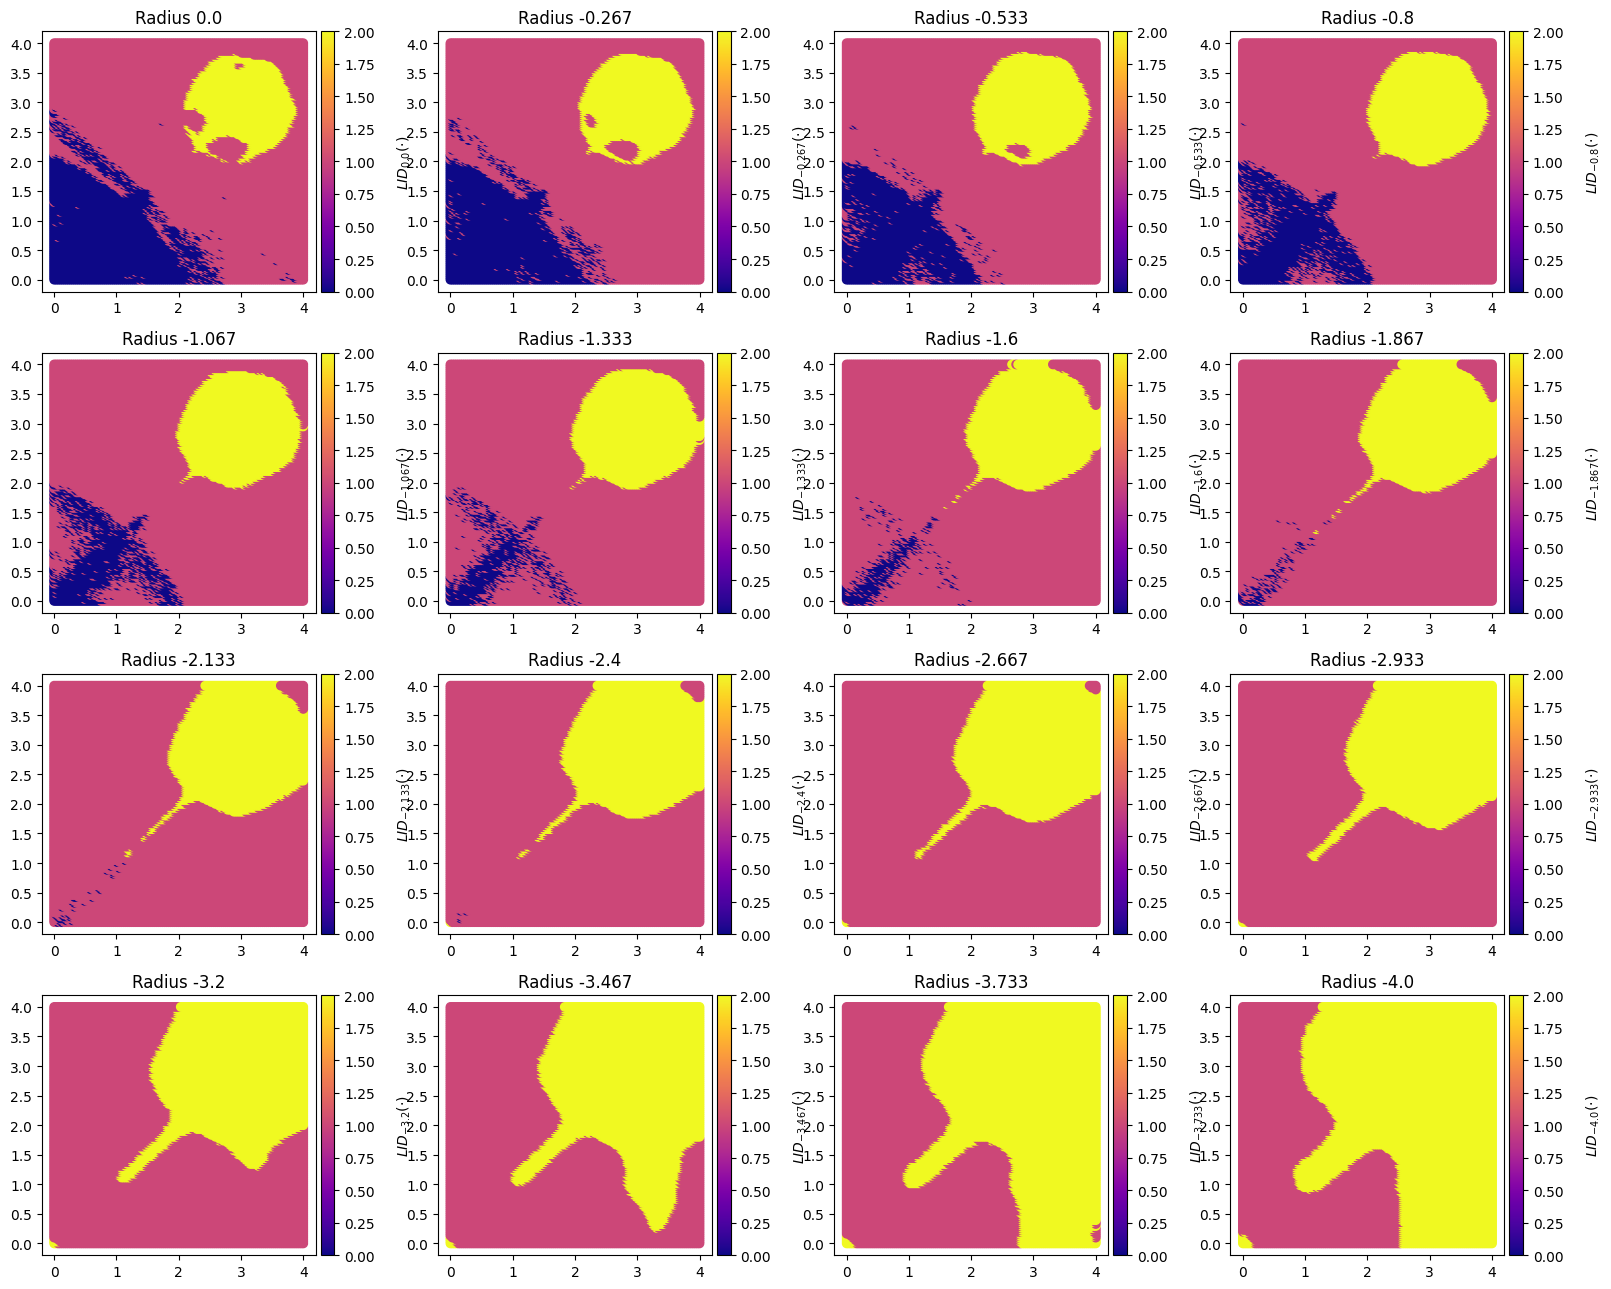

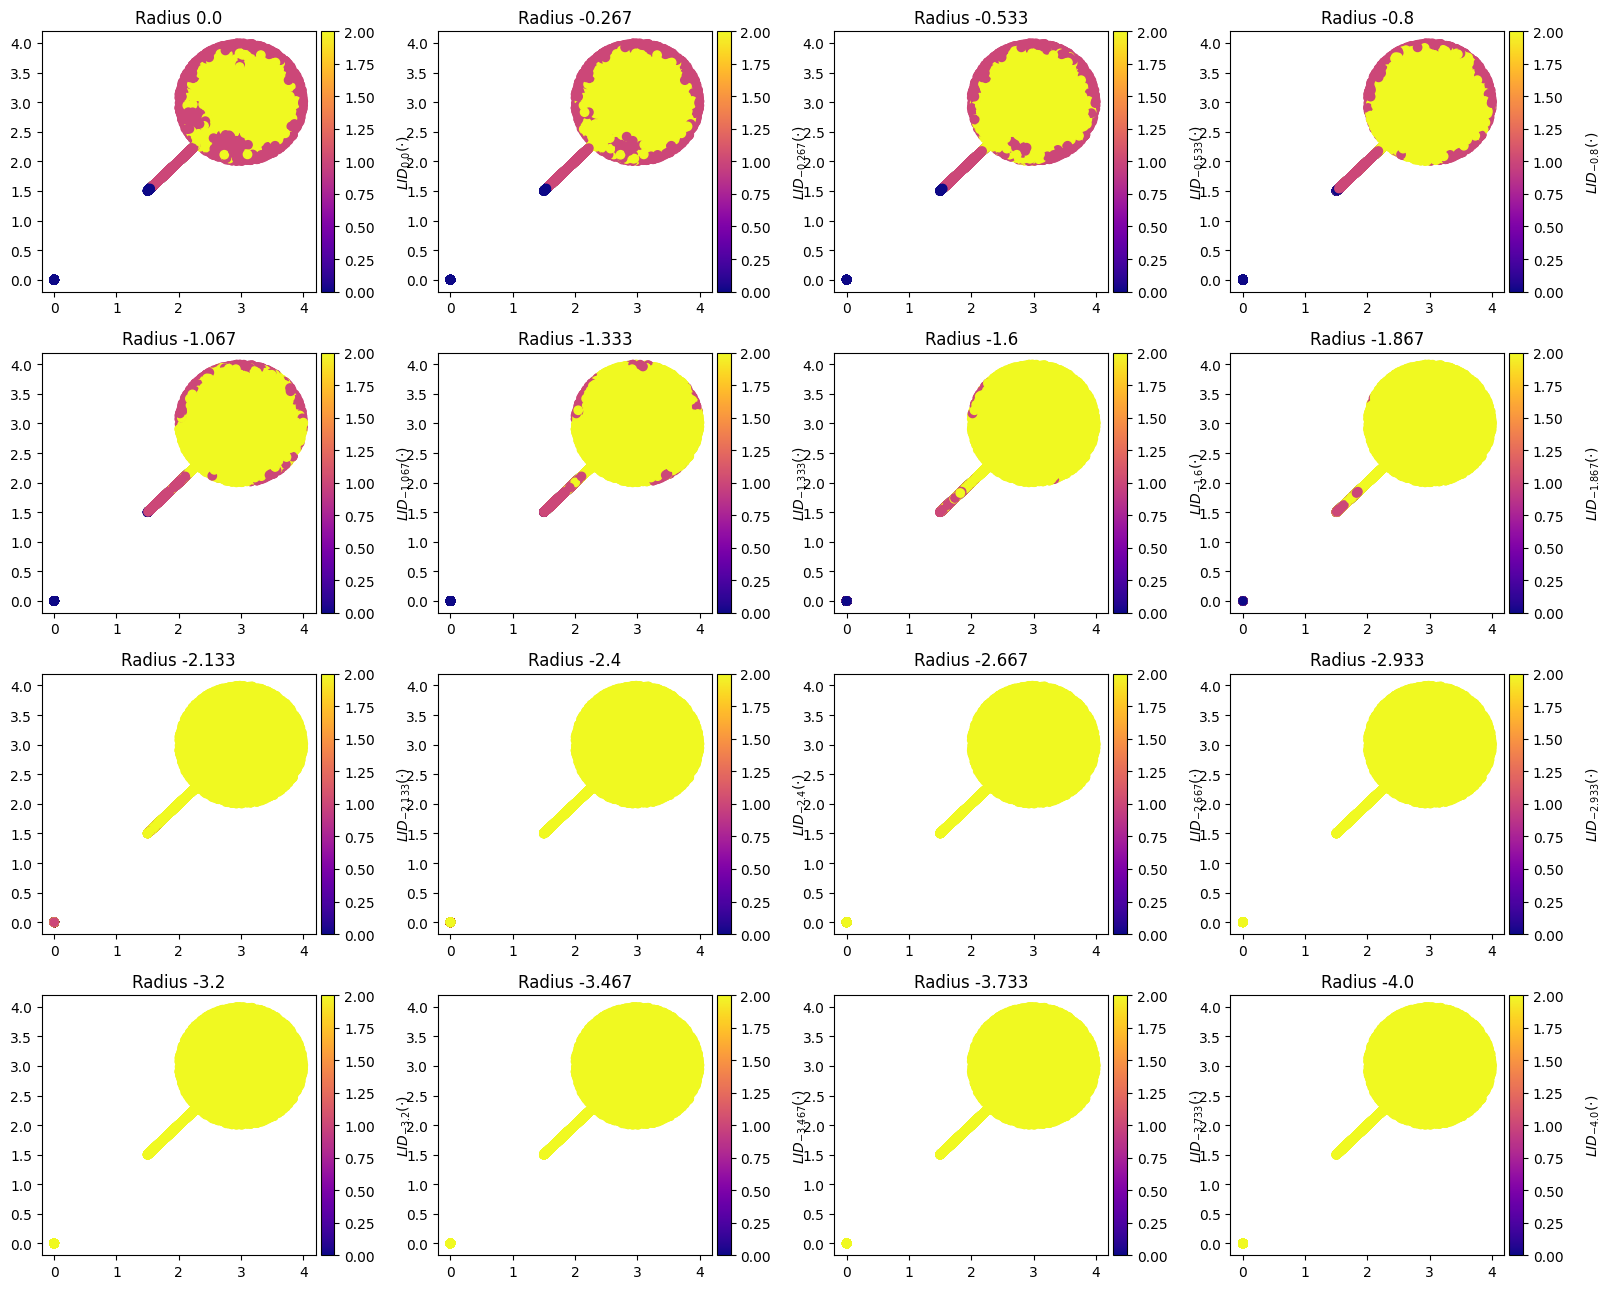

In [24]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np 

# Create an N by 2 dataset of points on a grid between 0 and 4
N = 123
x = np.linspace(0, 4, N)
y = np.linspace(0, 4, N)
X, Y = np.meshgrid(x, y)
data = np.vstack([X.ravel(), Y.ravel()]).T
data = torch.tensor(data, dtype=torch.float32).to(device)

def show_everything(data):
    radii = np.linspace(0, -4, 16)

    fig, axes = plt.subplots(4, 4, figsize=(16, 13))
    assert len(radii) == len(axes.flatten())

    for ax, r in tqdm(zip(axes.flatten(), radii), total=len(radii), desc="computing LID"): # Generate 1k points and plot them
        
        all_lid = model.lid(data, r=r, device=device).cpu()
        
        # Graph the norms
        s = ax.scatter(*data.cpu().T, c=all_lid, cmap='plasma', vmin=0, vmax=2)
        
        ax.set_title(f'Radius {round(r, 3)}')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(s, cax=cax, orientation='vertical')
        
        cbar.set_label(f'$LID_{{{round(r, 3)}}}(\\cdot)$', rotation=90, labelpad=15)


        
    fig.tight_layout()

show_everything(data)
show_everything(lollipop.data_projected)